In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import time
import subprocess

In [ ]:
!pip install thop
!pip install nvidia-ml-py3

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetPowerUsage, nvmlDeviceGetTemperature

In [ ]:
# Initialize NVML

nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# GPU setup
gpu_device = 0  # GPU device ID
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[gpu_device], True)
    tf.config.set_visible_devices(physical_devices[gpu_device], 'GPU')

In [ ]:
# Define a function to load SemEval-2016 Task 4 Subtask A data
def load_semeval_subtask_a(file_path):
    texts = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 3:  # Ensure there are three parts separated by tabs
                _, label, text = parts
                texts.append(text)
                labels.append(label)
    return texts, labels

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing URLs
    text = re.sub(r'http\S+', '', text)

    # Removing mentions
    text = re.sub(r'@\w+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing punctuation and non-alphanumeric characters
    tokens = [word for word in tokens if word.isalnum()]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [ ]:
# Load training data
train_texts, train_labels = load_semeval_subtask_a('twitter-2015train-A.txt')

# Load development data
dev_texts, dev_labels = load_semeval_subtask_a('twitter-2016dev-A.txt')

# Load development test data
devtest_texts, devtest_labels = load_semeval_subtask_a('twitter-2016test-A.txt')

# Load testing data
test_texts, test_labels = load_semeval_subtask_a('twitter-2016train-A.txt')

In [ ]:
# Combine development and development test data into one set (as per instructions)
dev_texts.extend(devtest_texts)
dev_labels.extend(devtest_labels)

# Preprocess the text data
train_texts = [preprocess_text(text) for text in train_texts]
dev_texts = [preprocess_text(text) for text in dev_texts]
test_texts = [preprocess_text(text) for text in test_texts]

# Tokenize the text data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_texts)

# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
dev_sequences = tokenizer.texts_to_sequences(dev_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to ensure uniform length
max_length = max(len(seq) for seq in train_sequences + dev_sequences + test_sequences)
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length)
dev_sequences = tf.keras.preprocessing.sequence.pad_sequences(dev_sequences, maxlen=max_length)
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length)

# Convert labels to numeric format
label_to_index = {'positive': 0, 'neutral': 1, 'negative': 2}
train_labels = np.array([label_to_index[label] for label in train_labels])
dev_labels = np.array([label_to_index[label] for label in dev_labels])
test_labels = np.array([label_to_index[label] for label in test_labels])

In [ ]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Record start time for training
start_time = time.time()

# Train the model
history = model.fit(train_sequences, train_labels,
                    validation_data=(dev_sequences, dev_labels),
                    epochs=10, batch_size=64)

# Record end time for training
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/10
8/8 [==============================] - 9s 461ms/step - loss: 1.0809 - accuracy: 0.5051 - val_loss: 1.0513 - val_accuracy: 0.4907
Epoch 2/10
8/8 [==============================] - 3s 345ms/step - loss: 1.0136 - accuracy: 0.5174 - val_loss: 1.0156 - val_accuracy: 0.4907
Epoch 3/10
8/8 [==============================] - 3s 345ms/step - loss: 0.9727 - accuracy: 0.5174 - val_loss: 1.0269 - val_accuracy: 0.4907
Epoch 4/10
8/8 [==============================] - 3s 464ms/step - loss: 0.9357 - accuracy: 0.5174 - val_loss: 1.0045 - val_accuracy: 0.4910
Epoch 5/10
8/8 [==============================] - 2s 316ms/step - loss: 0.8713 - accuracy: 0.5297 - val_loss: 1.0093 - val_accuracy: 0.4914
Epoch 6/10
8/8 [==============================] - 2s 291ms/step - loss: 0.7171 - accuracy: 0.7403 - val_loss: 1.0321 - val_accuracy: 0.5218
Epoch 7/10
8/8 [==============================] - 2s 307ms/step - loss: 0.4898 - accuracy: 0.8200 - val_loss: 1.0692 - val_accuracy: 0.4666
Epoch 8/10
8/8 [====

188/188 [==============================] - 1s 4ms/step - loss: 2.0365 - accuracy: 0.3213


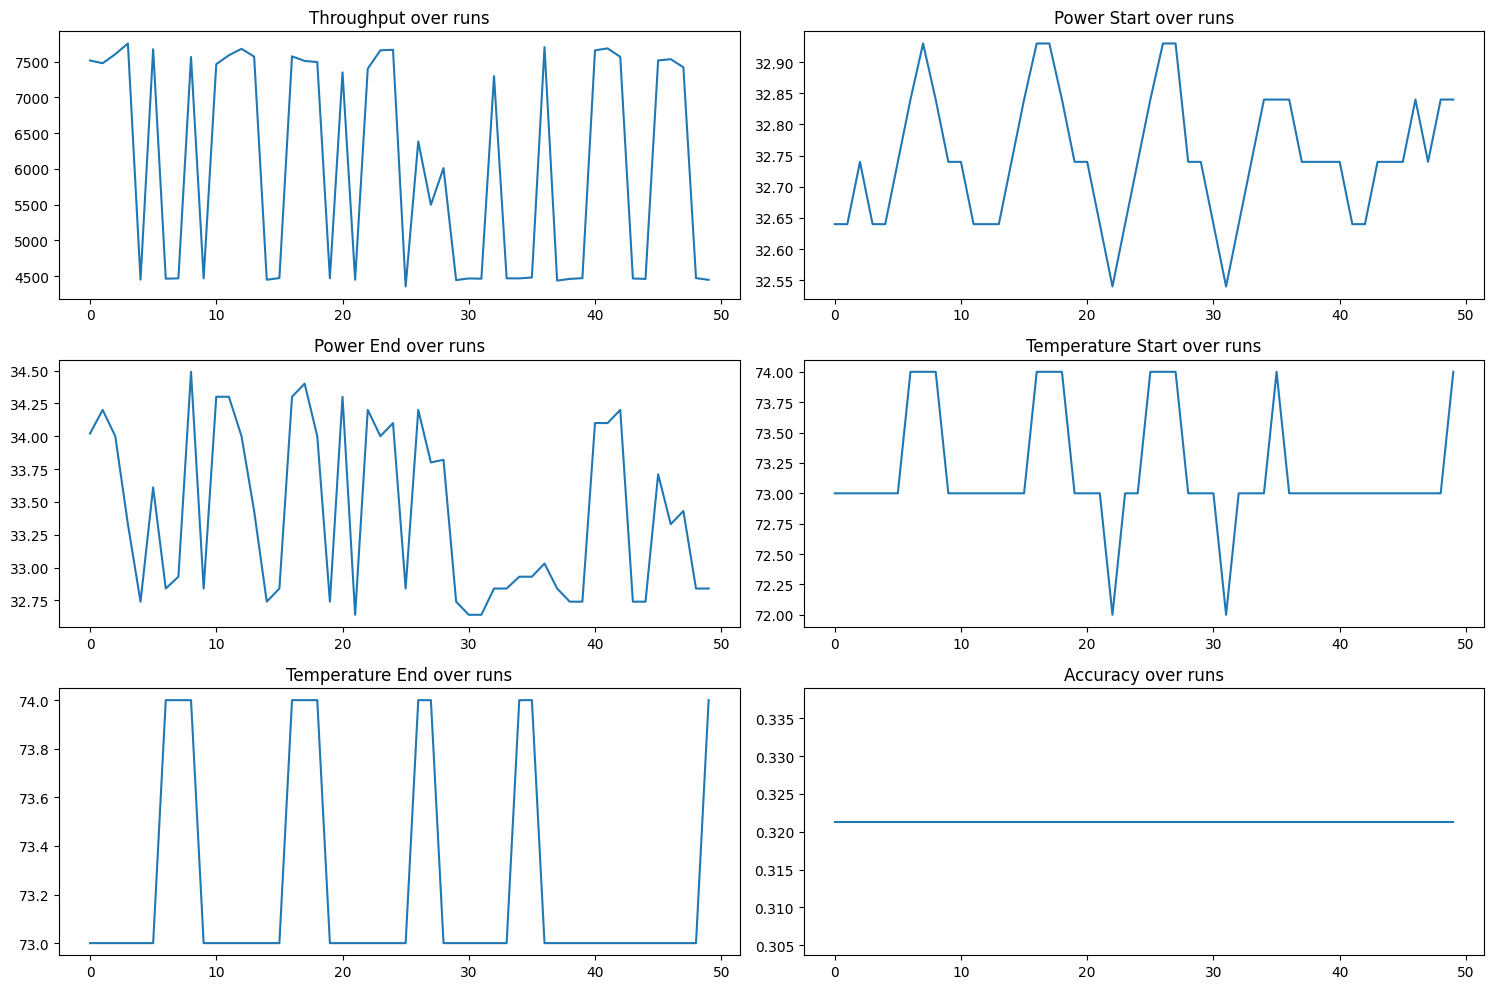

In [ ]:
import time
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

def get_gpu_info():
    smi_command = "nvidia-smi --query-gpu=name,memory.total,memory.used,memory.free,temperature.gpu,power.draw --format=csv"
    try:
        output = subprocess.check_output(smi_command, shell=True, text=True)
        lines = output.split('\n')
        headers = lines[0].split(',')
        temp_index = headers.index(' temperature.gpu')
        power_index = headers.index(' power.draw [W]')
        temperature = float(lines[1].split(',')[temp_index].strip())
        power_draw = float(lines[1].split(',')[power_index].strip().split(' W')[0])  # Remove ' W' and convert to float
        return temperature, power_draw
    except subprocess.CalledProcessError:
        print("Failed to get GPU information")
        return None, None

# Lists to store the metrics for each run
throughputs = []
power_starts = []
power_ends = []
temperatures_start = []
temperatures_end = []
temperatures_diff = []
power_diff = []
accuracies = []

# Loop to perform 50 runs
for i in range(50):
    # Record start time for evaluation and get initial GPU stats
    start_time = time.time()
    temperature_start, power_start = get_gpu_info()

    # Model evaluation code here
    test_loss, test_acc = model.evaluate(test_sequences, test_labels)

    # Record end time for evaluation and get final GPU stats
    end_time = time.time()
    temperature_end, power_end = get_gpu_info()

    # Calculate throughput
    num_samples = len(test_sequences)
    throughput = num_samples / (end_time - start_time)

    # Store results
    throughputs.append(throughput)
    power_starts.append(power_start)
    power_ends.append(power_end)
    temperatures_start.append(temperature_start)
    temperatures_end.append(temperature_end)
    temperatures_diff.append(temperature_end-temperature_start)
    power_diff.append(power_start-power_end)
    accuracies.append(test_acc)

    # Wait for 50 seconds before the next run
    time.sleep(10)

# Create DataFrame from results
df = pd.DataFrame({
    "Throughput": throughputs,
    "Power Start": power_starts,
    "Power End": power_ends,
    "Power Diff" : power_diff,
    "Temperature Start": temperatures_start,
    "Temperature End": temperatures_end,
    "Temperature Diff": temperatures_diff,
    "Accuracy": accuracies
})

# Calculate average of each column
averages = df.mean()

# Save averages to CSV
averages.to_csv("averages.csv")

# Plot graphs
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs[0, 0].plot(throughputs)
axs[0, 0].set_title("Throughput over runs")
axs[0, 1].plot(power_starts)
axs[0, 1].set_title("Power Start over runs")
axs[1, 0].plot(power_ends)
axs[1, 0].set_title("Power End over runs")
axs[1, 1].plot(temperatures_start)
axs[1, 1].set_title("Temperature Start over runs")
axs[2, 0].plot(temperatures_end)
axs[2, 0].set_title("Temperature End over runs")
axs[2, 1].plot(accuracies)
axs[2, 1].set_title("Accuracy over runs")

# Display graphs
plt.tight_layout()
plt.show()


In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Define a function to preprocess input phrases
def preprocess_phrases(phrases):
    preprocessed_phrases = [preprocess_text(phrase) for phrase in phrases]
    sequences = tokenizer.texts_to_sequences(preprocessed_phrases)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length)
    return padded_sequences

# Perform forward passes for phrases
phrases = ["I like apples.", "The weather is nice today.", "I am feeling happy.", "I dislike rainy days.", "I am not satisfied with the service."]
num_passes = 5

for phrase in phrases:
    phrase_outputs = []
    preprocessed_phrase = preprocess_phrases([phrase])
    for _ in range(num_passes):
        start_time = time.time()
        output = model.predict(preprocessed_phrase)
        end_time = time.time()
        phrase_outputs.append(output)
        print("Phrase:", phrase)
        print("Output values:", output)
        print("Time taken:", end_time - start_time, "seconds")
        print()

# Check the first few training texts to ensure they are properly preprocessed
print("First few training texts:")
for text in train_texts[:5]:
    print(text)

# Check the tokenizer's word index
print("Tokenizer Word Index:", tokenizer.word_index)